<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sample-Training-Stimuli" data-toc-modified-id="Sample-Training-Stimuli-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sample Training Stimuli</a></span></li><li><span><a href="#Visualize-Conditions" data-toc-modified-id="Visualize-Conditions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visualize Conditions</a></span></li><li><span><a href="#Run-Function-Learning-Task" data-toc-modified-id="Run-Function-Learning-Task-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run Function-Learning Task</a></span></li><li><span><a href="#Save-Simulated-Data" data-toc-modified-id="Save-Simulated-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save Simulated Data</a></span></li><li><span><a href="#Plot-Movements-in-Space" data-toc-modified-id="Plot-Movements-in-Space-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot Movements in Space</a></span></li><li><span><a href="#True-y-Value-vs.-Size-of-Change" data-toc-modified-id="True-y-Value-vs.-Size-of-Change-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>True y Value vs. Size of Change</a></span></li><li><span><a href="#Local-Change-vs.-Size-of-Change" data-toc-modified-id="Local-Change-vs.-Size-of-Change-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Local Change vs. Size of Change</a></span></li><li><span><a href="#Prediction-Uncertainty-vs.-Size-of-Change" data-toc-modified-id="Prediction-Uncertainty-vs.-Size-of-Change-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Prediction Uncertainty vs. Size of Change</a></span></li><li><span><a href="#Correlations-Between-Movements-in-Different-Conditions" data-toc-modified-id="Correlations-Between-Movements-in-Different-Conditions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Correlations Between Movements in Different Conditions</a></span></li><li><span><a href="#Plot-Changes-in-Uncertainty" data-toc-modified-id="Plot-Changes-in-Uncertainty-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Plot Changes in Uncertainty</a></span></li></ul></div>

In [1]:
from functools import reduce, partial
from itertools import repeat
from datetime import date
import sys
import multiprocessing
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append("..")

In [2]:
# home-grown modules
import py_utils.utils as utils
import py_utils.plotting as plot_utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid")

In [5]:
plt.style.use("presentation.mplstyle")

In [6]:
dict_variables = dict({
    "condition" : ["smooth", "rough"],
    "sampling_strategy": ["stimulus"],
    "prior_sd" : [.25],
    "sampling" : ["improvement"], # "metropolis-hastings", 
    "constrain_space" : [False], # True, 
    "space_edge_min" : [0],
    "space_edge_max" : [12],
    "n_features" : [2],
    "n_training" : [int(12**2/4), 0],
    "n_samples_block" : [200],
    "beta_softmax": [1, 10],
    "n_runs" : [50]
})

In [7]:
df_info, l_info, l_titles = utils.simulation_conditions(dict_variables, "reward")

# Sample Training Stimuli

In [8]:
make_stimuli_partial = partial(utils.make_stimuli, map_to_reward=True)
l_df_xy = list(map(make_stimuli_partial, l_info))

# Visualize Conditions

In [9]:
df_info

,condition,sampling_strategy,prior_sd,sampling,constrain_space,space_edge_min,space_edge_max,n_features,n_training,n_samples_block,beta_softmax,n_runs,length_scale
0,smooth,stimulus,0.25,improvement,False,0,12,2,36,200,1,50,3
1,smooth,stimulus,0.25,improvement,False,0,12,2,36,200,10,50,3
2,smooth,stimulus,0.25,improvement,False,0,12,2,0,200,1,50,3
3,smooth,stimulus,0.25,improvement,False,0,12,2,0,200,10,50,3
4,rough,stimulus,0.25,improvement,False,0,12,2,36,200,1,50,1
5,rough,stimulus,0.25,improvement,False,0,12,2,36,200,10,50,1
6,rough,stimulus,0.25,improvement,False,0,12,2,0,200,1,50,1
7,rough,stimulus,0.25,improvement,False,0,12,2,0,200,10,50,1


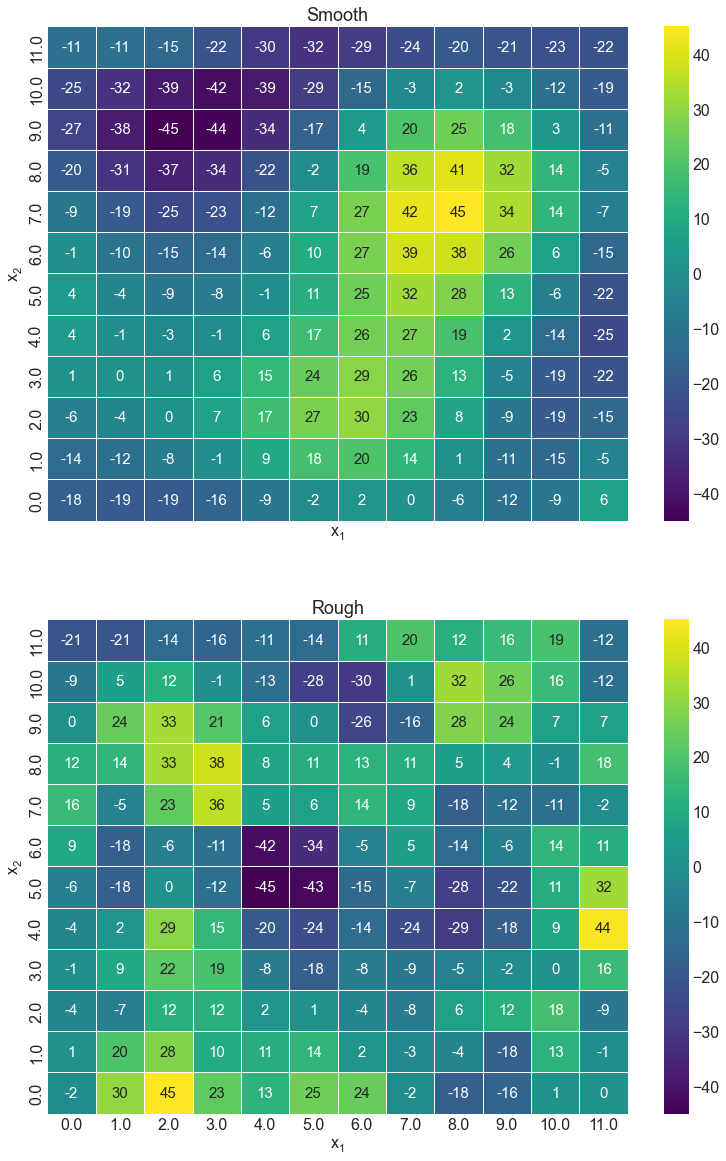

In [10]:
idxs=[0, len(l_info) - 1]
f, axes = plt.subplots(
    len(idxs), 1, sharex=True, sharey=True, figsize=(13, len(idxs) * 10)
)
plot_utils.plot_heatmaps(l_info, axes, idxs=idxs, map_to_reward=True)

the following only works if there are conditions where n training examples > 0
idx0 and idx1 have to be chosen accordingly 

C:\Users\Mirko\AppData\Local\Temp/ipykernel_23492/2894325110.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


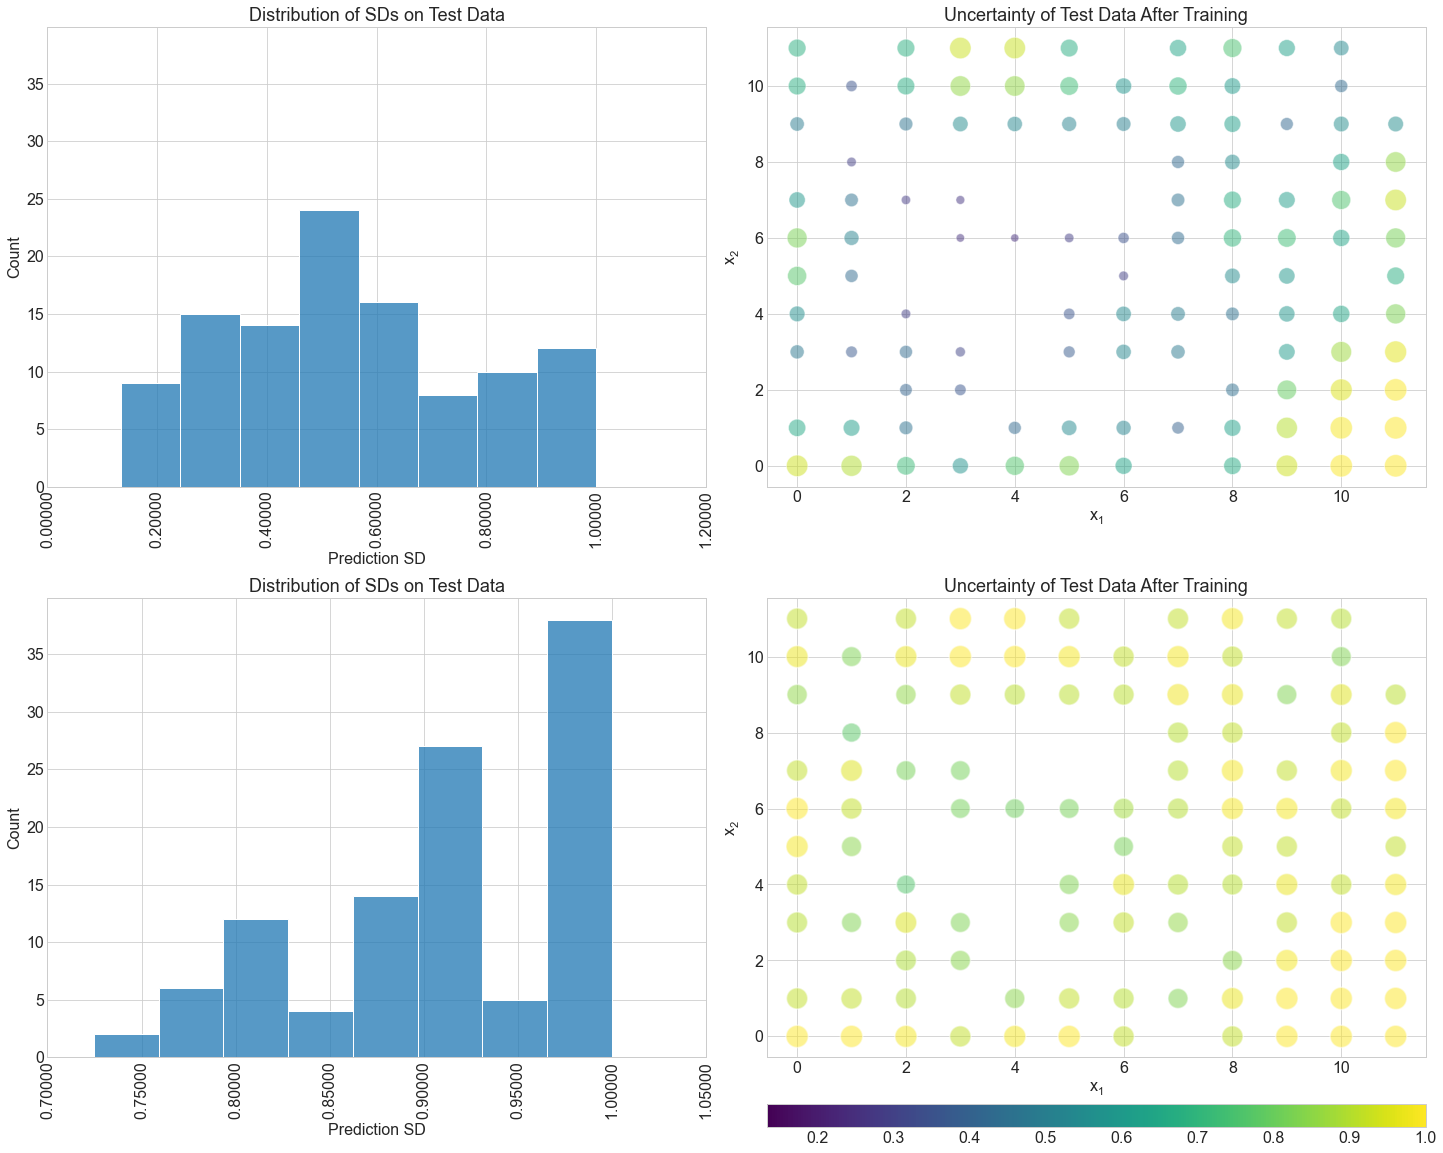

In [11]:
idx0 = 0
idx1 = len(l_info) - 3
float_formatter = "{:.5f}".format
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20, 16), sharex=False, sharey="col",
                  gridspec_kw={"height_ratios":[1, 1]})
axes_flat = axes.flatten()
l_df_xy[idx0], l_ivs, scaler = utils.scale_ivs(l_df_xy[idx0])
l_df_xy[idx1], l_ivs, scaler = utils.scale_ivs(l_df_xy[idx1])
df_train1, df_test1 = utils.split_train_test(l_info[idx0], l_df_xy[idx0])
df_train2, df_test2 = utils.split_train_test(l_info[idx1], l_df_xy[idx1])
# smooth
df_test1 = plot_utils.uncertainty_on_test_data(
    df_train1, df_test1, l_info[idx0], l_ivs
)
# rough
df_test2 = plot_utils.uncertainty_on_test_data(
    df_train2, df_test2, l_info[idx1], l_ivs
)
min_val = min(df_test1["y_pred_sd"].min(), df_test2["y_pred_sd"].min())
max_val = max(df_test1["y_pred_sd"].max(), df_test2["y_pred_sd"].max())

plot_utils.plot_uncertainty_on_test_data(df_test1, axes_flat[0:2], show_colorbar=False, min_val=min_val, max_val=max_val)
plot_utils.plot_uncertainty_on_test_data(df_test2, axes_flat[2:4], show_colorbar=False, min_val=min_val, max_val=max_val)


norm = plt.Normalize(
    min(df_test1["y_pred_sd"].min(), df_test2["y_pred_sd"].min()), 
    max(df_test1["y_pred_sd"].max(), df_test2["y_pred_sd"].max())
)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
axins = inset_axes(axes_flat[3],
                    width="100%",  
                    height="5%",
                    loc='lower center',
                    borderpad=-7
                   )
_ = fig.colorbar(sm, cax=axins, orientation="horizontal")
l_df_xy[idx0].drop([f"""{iv}_z""" for iv in l_ivs], axis=1, inplace=True)
l_df_xy[idx1].drop([f"""{iv}_z""" for iv in l_ivs], axis=1, inplace=True)

xt0 = [float_formatter(t) for t in axes_flat[0].get_xticks()]
axes_flat[0].xaxis.set_ticks([float(xv) for xv in xt0])
axes_flat[0].set_xticklabels(xt0, rotation=90)
xt2 = [float_formatter(t) for t in axes_flat[2].get_xticks()]
axes_flat[2].xaxis.set_ticks([float(xv) for xv in xt2])
_ = axes_flat[2].set_xticklabels(xt2, rotation=90)

plt.tight_layout()

# Run Function-Learning Task

In [12]:
df_info

,condition,sampling_strategy,prior_sd,sampling,constrain_space,space_edge_min,space_edge_max,n_features,n_training,n_samples_block,beta_softmax,n_runs,length_scale
0,smooth,stimulus,0.25,improvement,False,0,12,2,36,200,1,50,3
1,smooth,stimulus,0.25,improvement,False,0,12,2,36,200,10,50,3
2,smooth,stimulus,0.25,improvement,False,0,12,2,0,200,1,50,3
3,smooth,stimulus,0.25,improvement,False,0,12,2,0,200,10,50,3
4,rough,stimulus,0.25,improvement,False,0,12,2,36,200,1,50,1
5,rough,stimulus,0.25,improvement,False,0,12,2,36,200,10,50,1
6,rough,stimulus,0.25,improvement,False,0,12,2,0,200,1,50,1
7,rough,stimulus,0.25,improvement,False,0,12,2,0,200,10,50,1


df_xy = l_df_xy[2]
dict_info = l_info[2]
refit_gp = True
readjust_representations = True

df_xy, l_ivs, scaler = utils.scale_ivs(df_xy)
df_train, df_test = utils.split_train_test(dict_info, df_xy)
if dict_info["n_training"] > 0:
    # in that case people are trained on a proportion of the true x, y values
    # prediction on df_test is done also on the true x, y values
    gp = utils.fit_on_train(
        df_train, l_ivs, dict_info, fit_length_scale=True, update_length_scale=False
    )
    df_test = utils.predict_on_test(df_test, gp, l_ivs)
else:
    # here, people already start by perceiving noisy samples
    # from the prior and predict
    df_train = utils.perceive_block_stim(df_xy, scaler, dict_info, 1234, "sample")
    df_train.drop_duplicates(subset=["x_1", "x_2"], inplace=True)
    gp = utils.fit_on_train(
        df_train, l_ivs, dict_info, fit_length_scale=True, update_length_scale=False
    )
    df_test = df_xy

df_test_true = df_test.copy()
df_test_new = df_test.copy()
df_rewards = pd.DataFrame()
df_accepted = pd.DataFrame()
l_kernel = list()
l_kernel.append(gp.kernel_.length_scale)
for i in np.arange(dict_info["n_runs"]) + 1:
    np.random.seed()
    seeds = np.random.randint(0, 10000, 2)
    df_reward_fixed, reward_fixed, _, _ = utils.total_reward(
        [df_test, gp, scaler], dict_info, seeds, "fixed"
    )
    if i == 0:
        df_reward_fixed["trial_nr"] = 0
        df_rewards = pd.concat([df_rewards, df_reward_fixed])
    df_reward_sample, reward_sample, df_l, df_r = utils.total_reward(
        [df_test, gp, scaler], dict_info, seeds, "sample"
    )
    df_reward_sample["trial_nr"] = i
    print(
        "block: ",
        i,
        ", reward fixed: ",
        reward_fixed,
        ", reward sampled: ",
        reward_sample,
    )
    if reward_sample > reward_fixed:
        print(f"""got closer in block {i}""")
        df_accepted = pd.concat([df_l, df_r], axis=0)
        df_accepted["trial_nr"] = i
        df_accepted.drop_duplicates(subset=["stim_id"], inplace=True)
        df_test_new = pd.concat([df_test_new, df_accepted], axis=0)
        df_rewards = pd.concat([df_rewards, df_reward_sample])
        if refit_gp:
            gp = utils.fit_on_train(
                df_test_new,
                l_ivs,
                dict_info,
                fit_length_scale=True,
                update_length_scale=False,
            )
        l_kernel.append(gp.kernel_.length_scale)
        if readjust_representations:
            # move points in df_test to accepted samples
            keep = ~df_test["stim_id"].isin(df_accepted["stim_id"])
            df_test = pd.concat([df_test[keep], df_accepted], axis=0)

if df_accepted.shape[0] > 0:
    # if sampling from the prior helped:
    df_test_new = utils.add_x_deviation(df_test_new, df_test_true)
    df_test_true = utils.add_x_deviation(df_accepted, df_test_true)
else:
    # if no samples were accepted
    df_test_new = utils.add_x_deviation(df_test_true, df_test_true)
    df_test_true = utils.add_x_deviation(df_test_true, df_test_true)


In [13]:
n_cpus = min(len(l_info), multiprocessing.cpu_count() - 2)
p = multiprocessing.Pool(n_cpus)
#f_partial = partial(utils.run_perception, l_df_xy=l_df_xy)
# multiprocessing Pool map does not accept partial functions
list_perception = []
run_perception_pairs_partial = partial(
    utils.run_perception_pairs, refit_gp = True, readjust_representations = True
)
for x in tqdm(p.starmap(run_perception_pairs_partial, zip(l_info, l_df_xy))):
    list_perception.append(x)

  0%|          | 0/8 [00:00<?, ?it/s]

In [14]:
list_df_new_xpos = [l[0].reset_index() for l in list_perception]
list_df_reward = [l[1] for l in list_perception]
list_df_trials = [l[2] for l in list_perception]
list_kernels = [l[3] for l in list_perception]

In [15]:
df_info

,condition,sampling_strategy,prior_sd,sampling,constrain_space,space_edge_min,space_edge_max,n_features,n_training,n_samples_block,beta_softmax,n_runs,length_scale
0,smooth,stimulus,0.25,improvement,False,0,12,2,36,200,1,50,3
1,smooth,stimulus,0.25,improvement,False,0,12,2,36,200,10,50,3
2,smooth,stimulus,0.25,improvement,False,0,12,2,0,200,1,50,3
3,smooth,stimulus,0.25,improvement,False,0,12,2,0,200,10,50,3
4,rough,stimulus,0.25,improvement,False,0,12,2,36,200,1,50,1
5,rough,stimulus,0.25,improvement,False,0,12,2,36,200,10,50,1
6,rough,stimulus,0.25,improvement,False,0,12,2,0,200,1,50,1
7,rough,stimulus,0.25,improvement,False,0,12,2,0,200,10,50,1


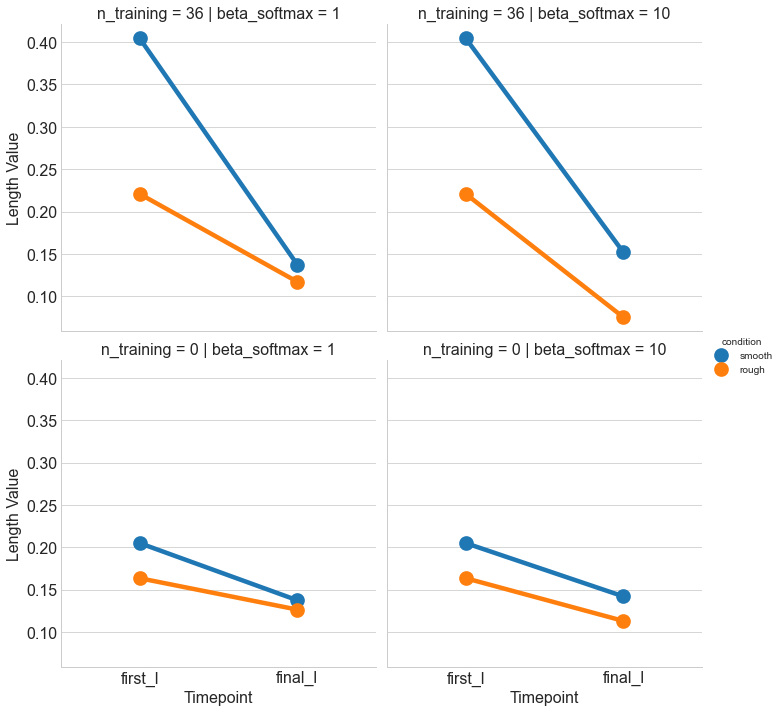

In [16]:
l_vars = ["condition", "n_training", "beta_softmax"]
df_info["first_l"] = [k[0] for k in list_kernels]
df_info["final_l"] = [k[-1] for k in list_kernels]
df_length = df_info.groupby(l_vars)[["first_l", "final_l"]].mean().reset_index()
df_length = df_length.melt(
    id_vars=l_vars, 
    value_vars=["first_l", "final_l"],
    var_name="Timepoint",
    value_name="Length Value"
)
_ = sns.catplot(
    x="Timepoint", y="Length Value", hue=l_vars[0], 
    row=l_vars[1], col=l_vars[2], kind="point", scale=5,
    data=df_length
)

# Save Simulated Data

In [17]:
str_today = str(date.today())

with open(f"""../data/{str_today}-reward-learning-dont-refit-gp.pickle""", "wb") as f:
    pickle.dump(list_perception, f)

with open(f"""../data/{str_today}-reward-learning-dont-refit-gp.pickle""", "rb") as f:
    list_perception = pickle.load(f)

- think about leaving in prior points when plotting movements (prior & likelihood...) as I did that in the category learning part

# Plot Movements in Space

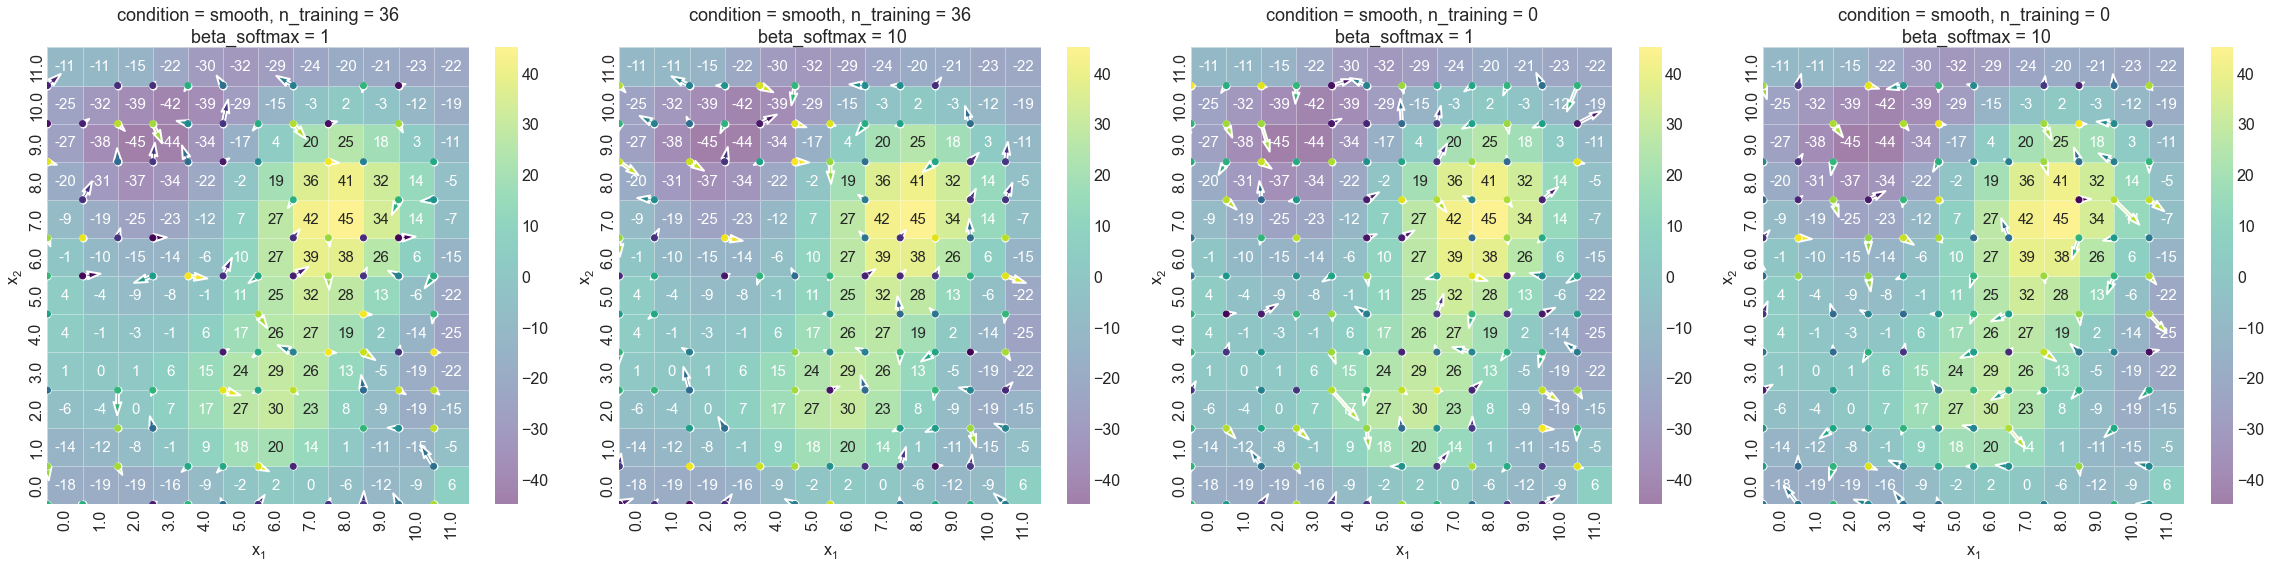

In [18]:
f_partial = partial(plot_utils.plot_moves_one_condition, list_dfs_new=list_df_new_xpos, df_info=df_info)
slices = slice(0, 4)
l_idxs = df_info.index[slices].to_list()
f, axes = plt.subplots(1, 4, figsize=(32, 8))
_ = list(map(f_partial, l_idxs, l_titles[slices], axes.flatten()))
plot_utils.plot_heatmaps(l_info, axes.flat, l_idxs, map_to_reward=True, l_titles=l_titles[slices], alpha=.5)
plt.tight_layout()
#plt.savefig(f"""../figures/{str_today}-reward-learning-smooth-movements.png""")

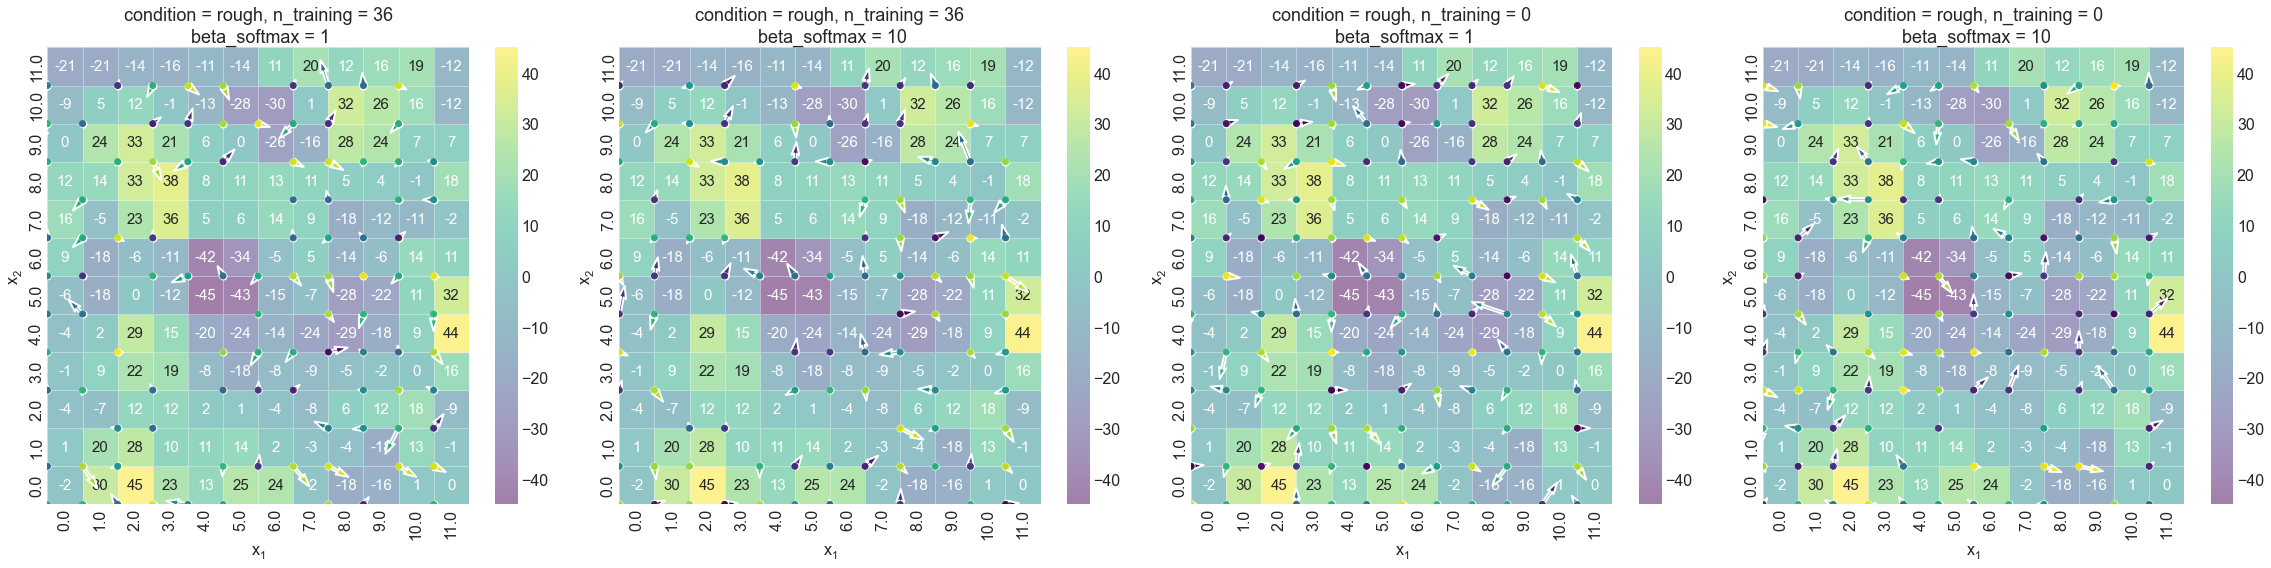

In [19]:
f_partial = partial(plot_utils.plot_moves_one_condition, list_dfs_new=list_df_new_xpos, df_info=df_info)
slices = slice(4, 8)
l_idxs = df_info.index[slices].to_list()
f, axes = plt.subplots(1, 4, figsize=(32, 8))
_ = list(map(f_partial, l_idxs, l_titles[slices], axes.flatten()))
plot_utils.plot_heatmaps(l_info, axes.flat, l_idxs, map_to_reward=True, l_titles=l_titles[slices], alpha=.5)
plt.tight_layout()
#plt.savefig(f"""../figures/{str_today}-reward-learning-rough-movements.png""")

# True y Value vs. Size of Change

In [20]:
list_df_new_xpos = list(map(utils.add_max_gradient, tqdm(list_df_new_xpos)))

  0%|          | 0/8 [00:00<?, ?it/s]

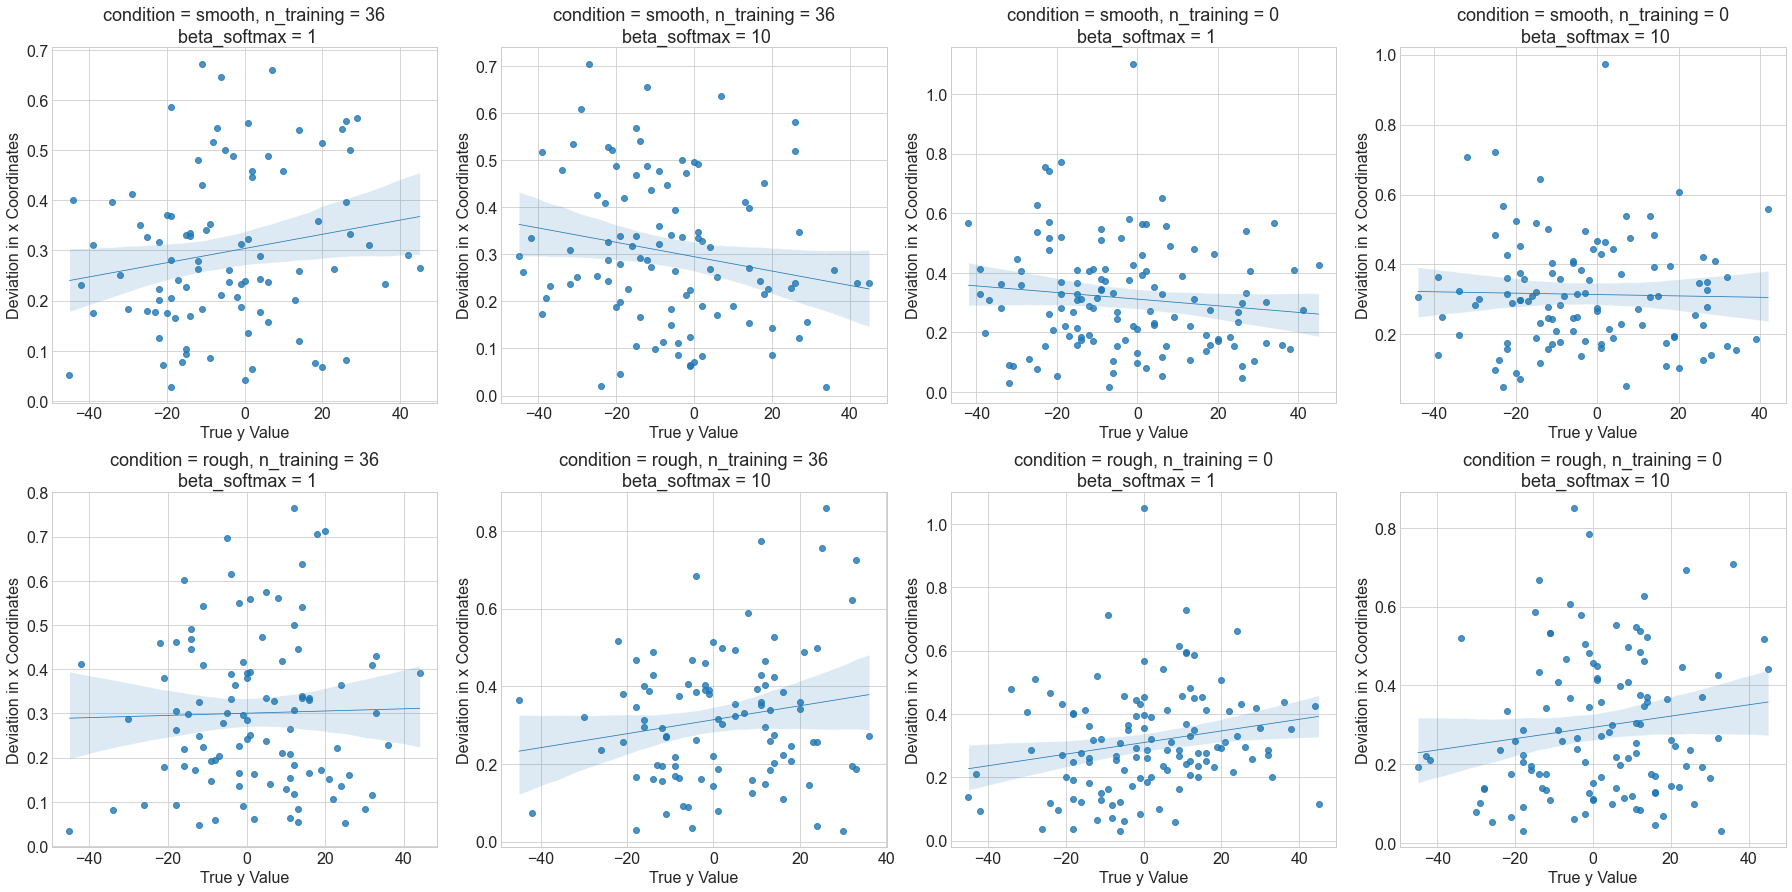

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12.5))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_y, list_df_new_xpos, l_titles, axes_flat))
plt.tight_layout()

# Local Change vs. Size of Change

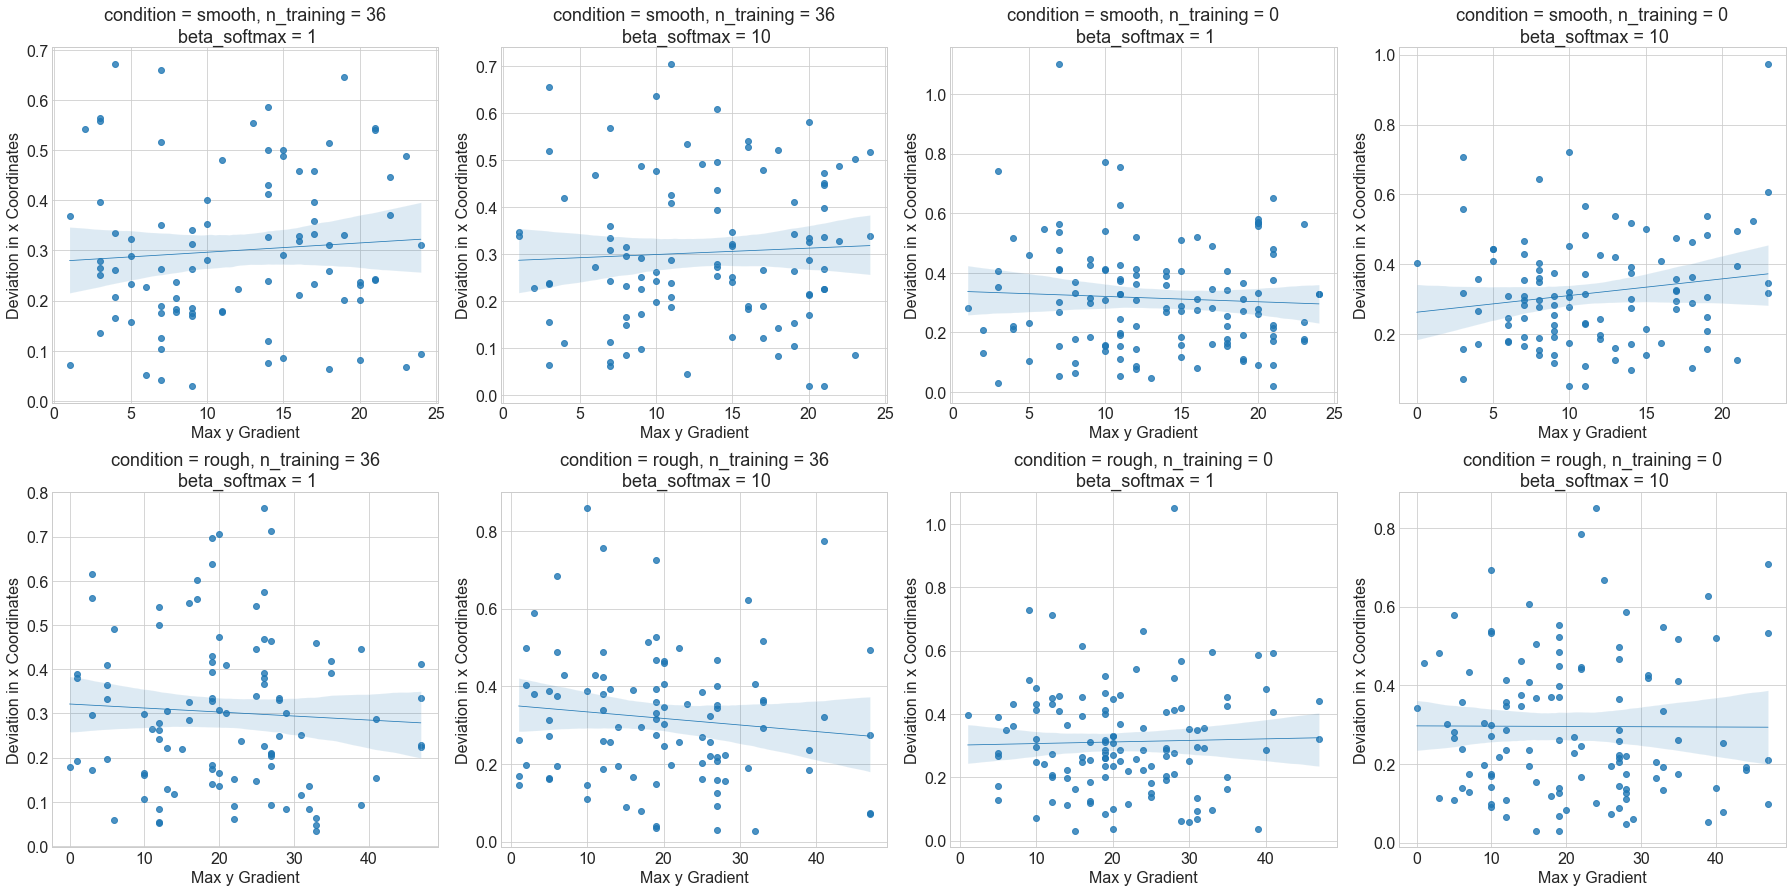

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12.5))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_max_gradient, list_df_new_xpos, l_titles, axes_flat))
plt.tight_layout()

# Prediction Uncertainty vs. Size of Change

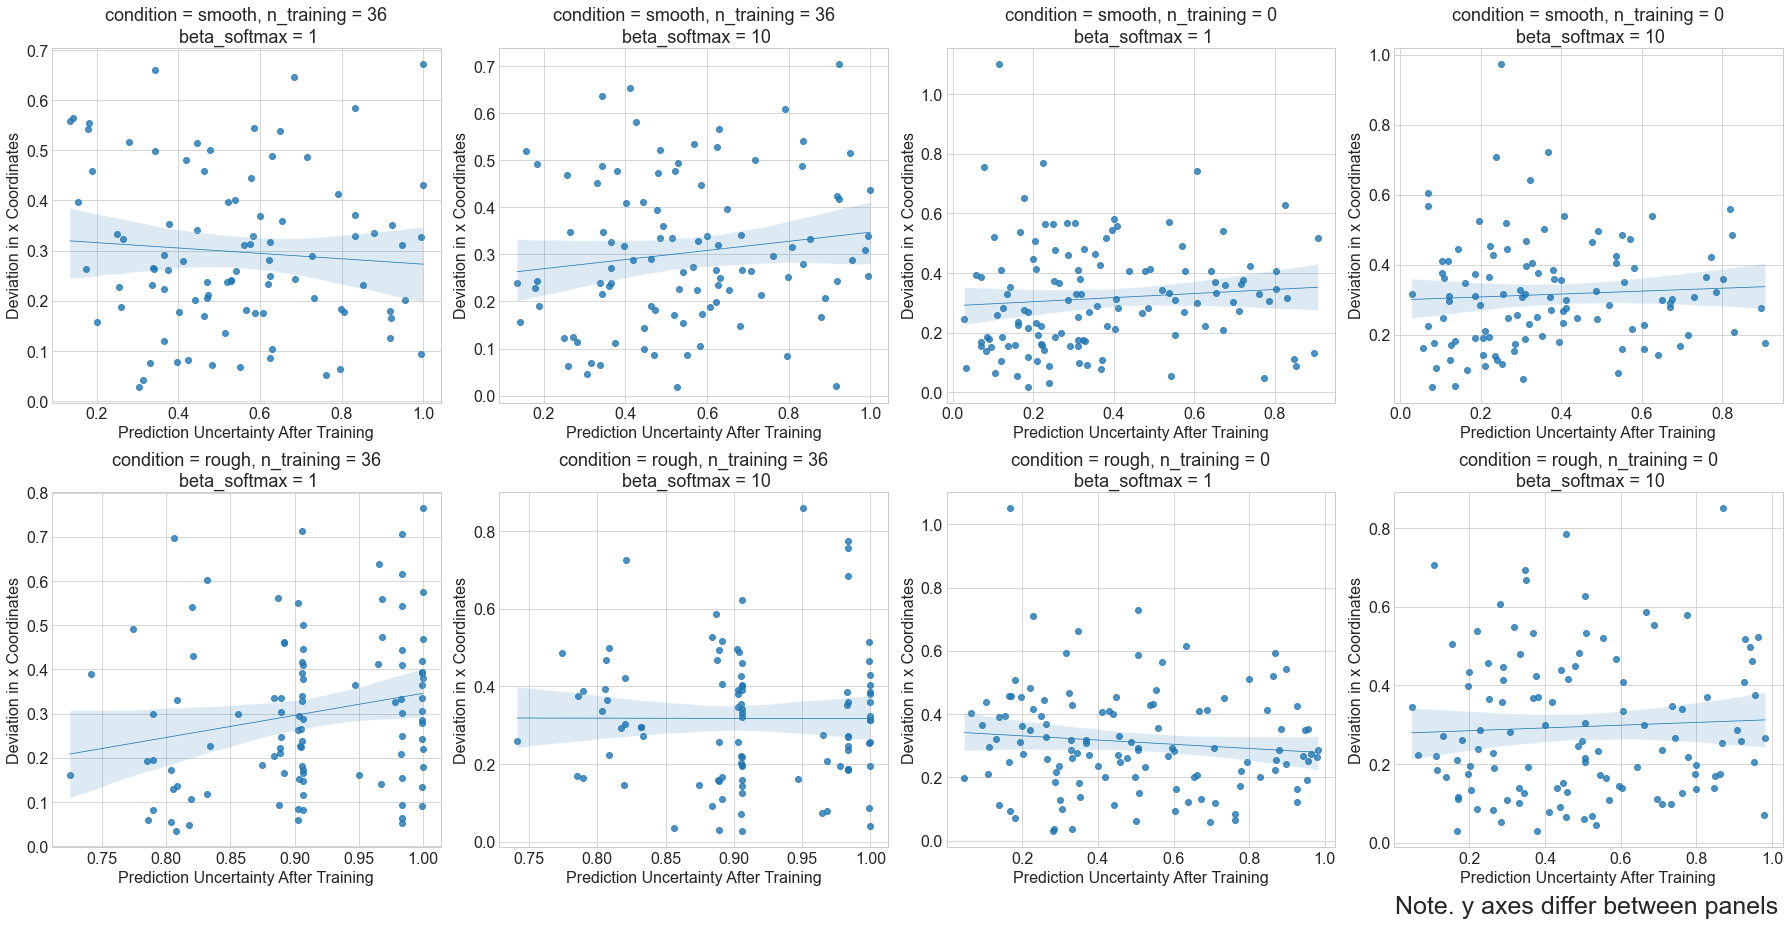

In [23]:
# Only take the first and the last miniblock for the next plot
l_last_trial = [l[l["trial_nr"].isin( [l["trial_nr"].max(), l["trial_nr"].min()])] for l in list_df_trials]

fig, axes = plt.subplots(2, 4, figsize=(25, 12.5))
axes_flat = axes.flatten()
_ = list(map(plot_utils.regplot_start_uncertainty, l_last_trial, l_titles, axes_flat))
plt.tight_layout()
str_note = "Note. y axes differ between panels"
_ = plt.figtext(0.99, -0.02, str_note, horizontalalignment='right', size=25)

# Correlations Between Movements in Different Conditions

In [24]:
l_df_movements = list(map(utils.add_angle_of_movements, list_df_new_xpos))

In [25]:
def correlation_between_movement_angles(idx1: int, idx2:int, l_df_movements: list) -> float:
    df_tmp = pd.merge(l_df_movements[idx1], l_df_movements[idx2], how="inner", left_index=True, right_index=True)
    return np.corrcoef(df_tmp["angle_x"], df_tmp["angle_y"])[0, 1]

In [26]:
df1 = pd.Series(range(len(l_df_movements)), name="Condition 1")
df2 = pd.Series(range(len(l_df_movements)), name="Condition 2")
df_cross = pd.merge(df1, df2, how="cross")
f_partial = partial(correlation_between_movement_angles, l_df_movements = l_df_movements)
df_cross["correlation"] = list(map(f_partial, df_cross["Condition 1"].to_list(), df_cross["Condition 2"].to_list()))

In [27]:
filt_info = (df_info["constrain_space"] == False)#(df_info["prior_sd"] == 1)# & 
idxs_required = df_info.loc[filt_info].index.to_list()#
filt = (df_cross["Condition 1"].isin(idxs_required)) & (df_cross["Condition 2"].isin(idxs_required))
df_cross = df_cross.loc[filt, ].copy()

In [28]:
df_cross["corr_above_0"] = df_cross["correlation"] > 0
prop_above_0 = (
    df_cross.query("`Condition 1` != `Condition 2`")["corr_above_0"].sum() / 
    df_cross.query("`Condition 1` != `Condition 2`").shape[0]
).round(2)
print("Proportion of Correlations > 0 between Movement Directions in Simulation Conditions: ", prop_above_0)

Proportion of Correlations > 0 between Movement Directions in Simulation Conditions:  0.29


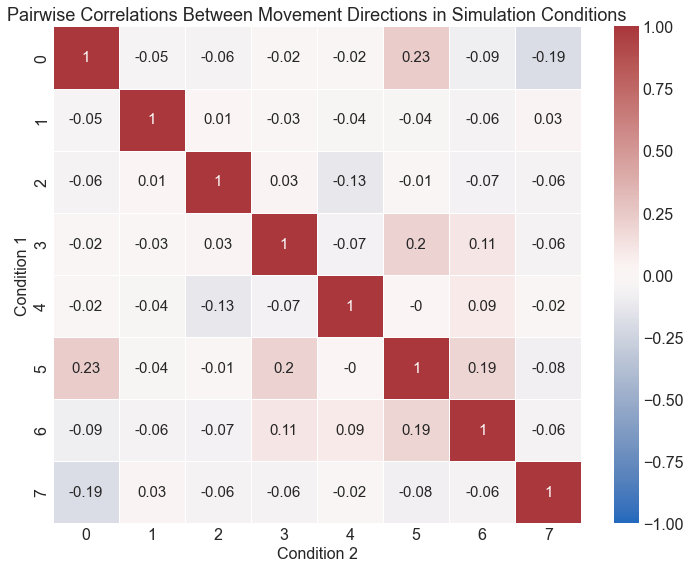

In [29]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    df_cross.pivot(index="Condition 1", columns="Condition 2", values="correlation").round(2), 
    annot=True, annot_kws={"size":15}, linewidths=1, cmap="vlag", vmin = -1, vmax = 1, ax=ax
)
_ = ax.set_title("Pairwise Correlations Between Movement Directions in Simulation Conditions")
plt.tight_layout()
# plt.savefig(f"""../figures/{str_today}-func-learning-pairwise-correlations-constrained-refit.png""")

# Plot Changes in Uncertainty

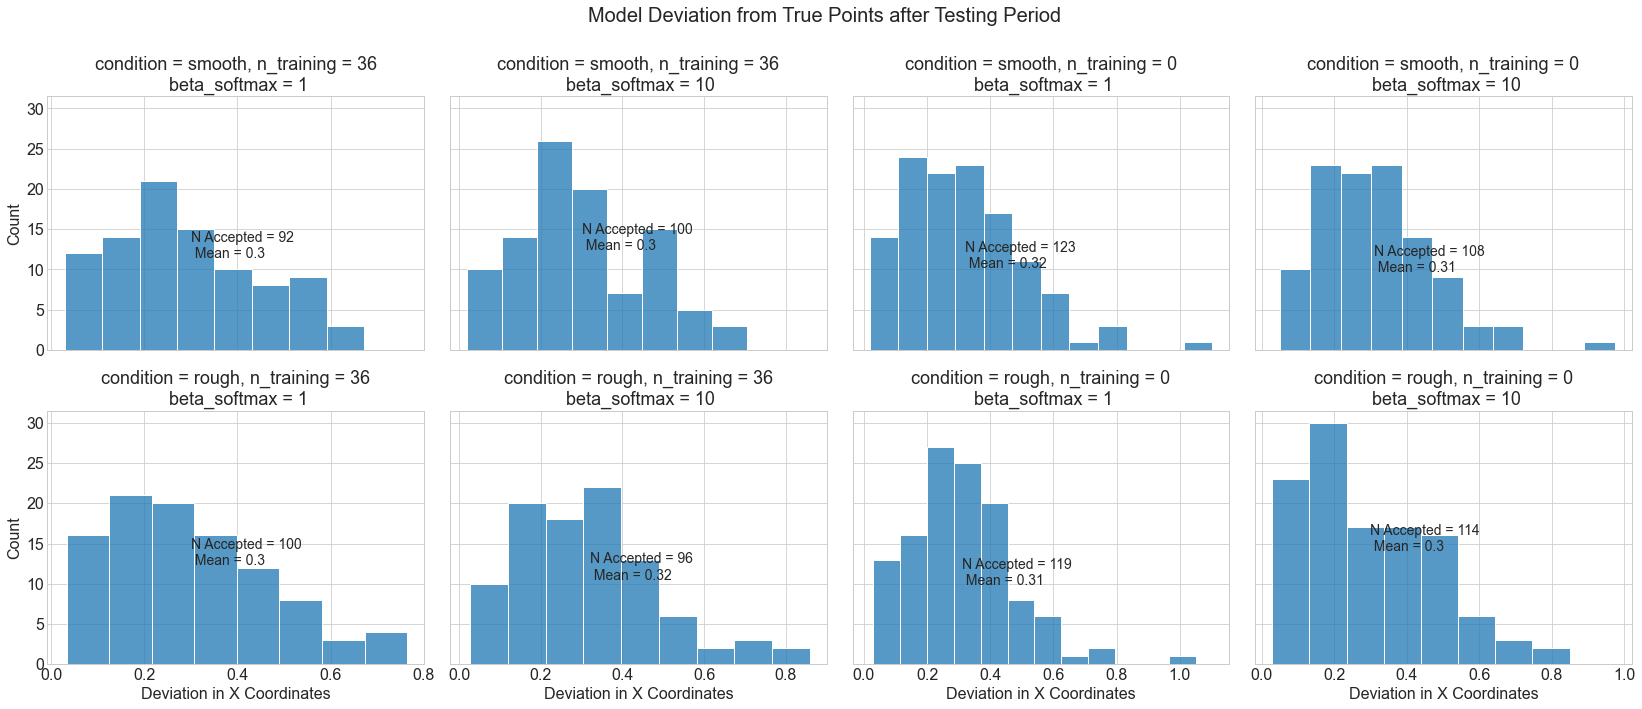

In [30]:
stim_id = 133 # but then 132 shows opposite pattern
l_idxs = [2, 6, 10, 14]
#l_idxs = [0, 4, 8, 12]
#l_idxs = [i + 1 for i in l_idxs]
l_idxs = range(0, 8)
n_plots = len(l_idxs)
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
f, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5.75, n_rows*5), sharex="col", sharey=True)
plot_utils.plot_gp_deviations(axes, l_idxs, list_df_trials, l_titles) # , stim_id
plt.suptitle("Model Deviation from True Points after Testing Period\n", size=20)
plt.tight_layout()

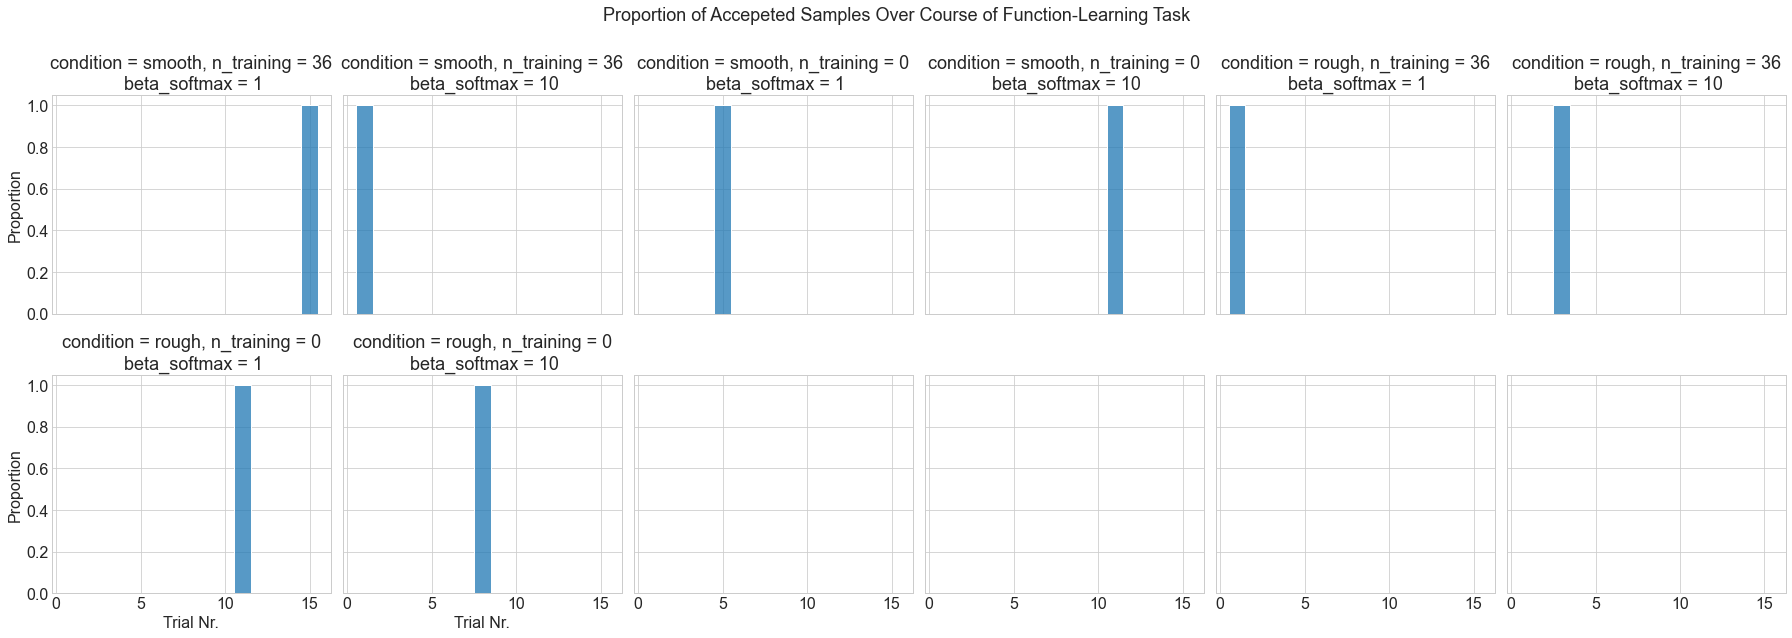

In [31]:
fig, axes = plt.subplots(2, 6, figsize=(25, 9), sharex=True, sharey=True)
f_partial = partial(plot_utils.plot_proportion_accepted_samples, n_runs=l_info[0]["n_runs"])
list(map(f_partial, list_df_trials, l_titles, axes.flatten()))
_ = fig.suptitle("Proportion of Accepeted Samples Over Course of Function-Learning Task\n")
plt.tight_layout()

In [32]:
for i in list_df_trials:
    i["r_sq"] = (i["y"] - i["y_pred_mn"])**2

C:\Users\Mirko\AppData\Local\Temp/ipykernel_23492/1601983770.py:5: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


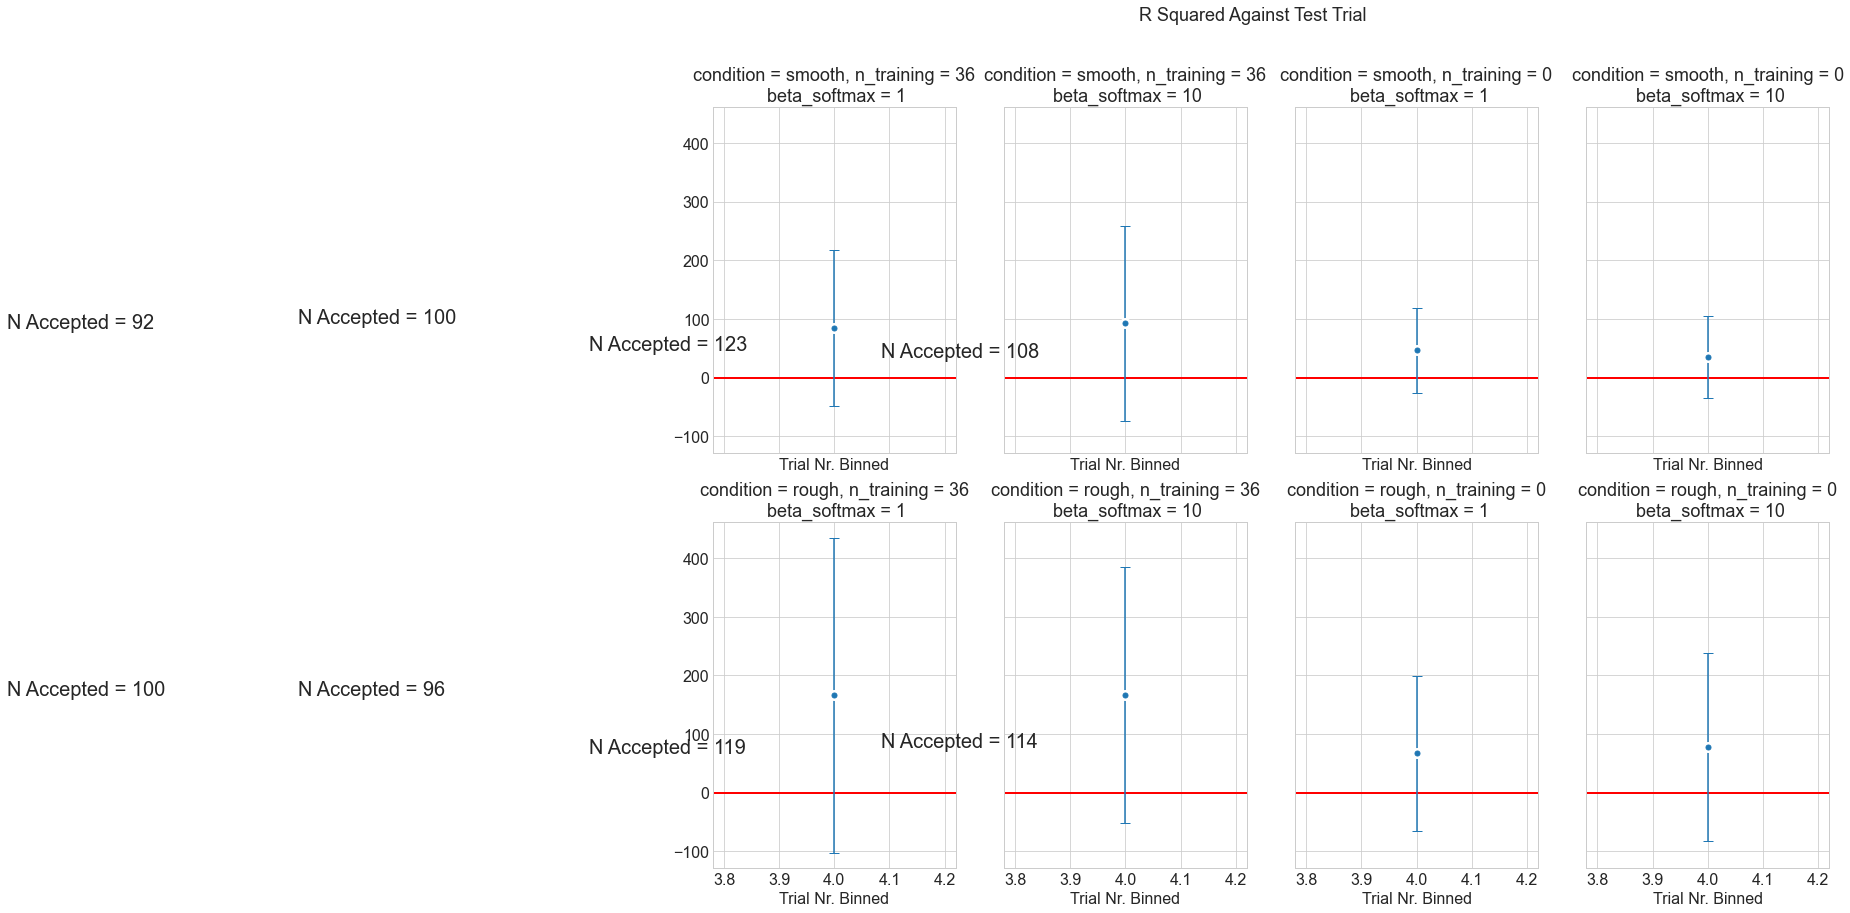

In [33]:
fig, axes = plt.subplots(2, 4, figsize=(20, 14), sharex=True, sharey=True)
plot_uncertainty_over_test_partial = partial(plot_utils.plot_var_over_bintime, var="r_sq")
list(map(plot_uncertainty_over_test_partial, list_df_trials, l_titles, axes.flatten()))
_ = fig.suptitle("R Squared Against Test Trial\n")
plt.tight_layout()
str_note = "Note. y axes differ between panels"
# _ = plt.figtext(0.99, -0.02, str_note, horizontalalignment='right', size=25)

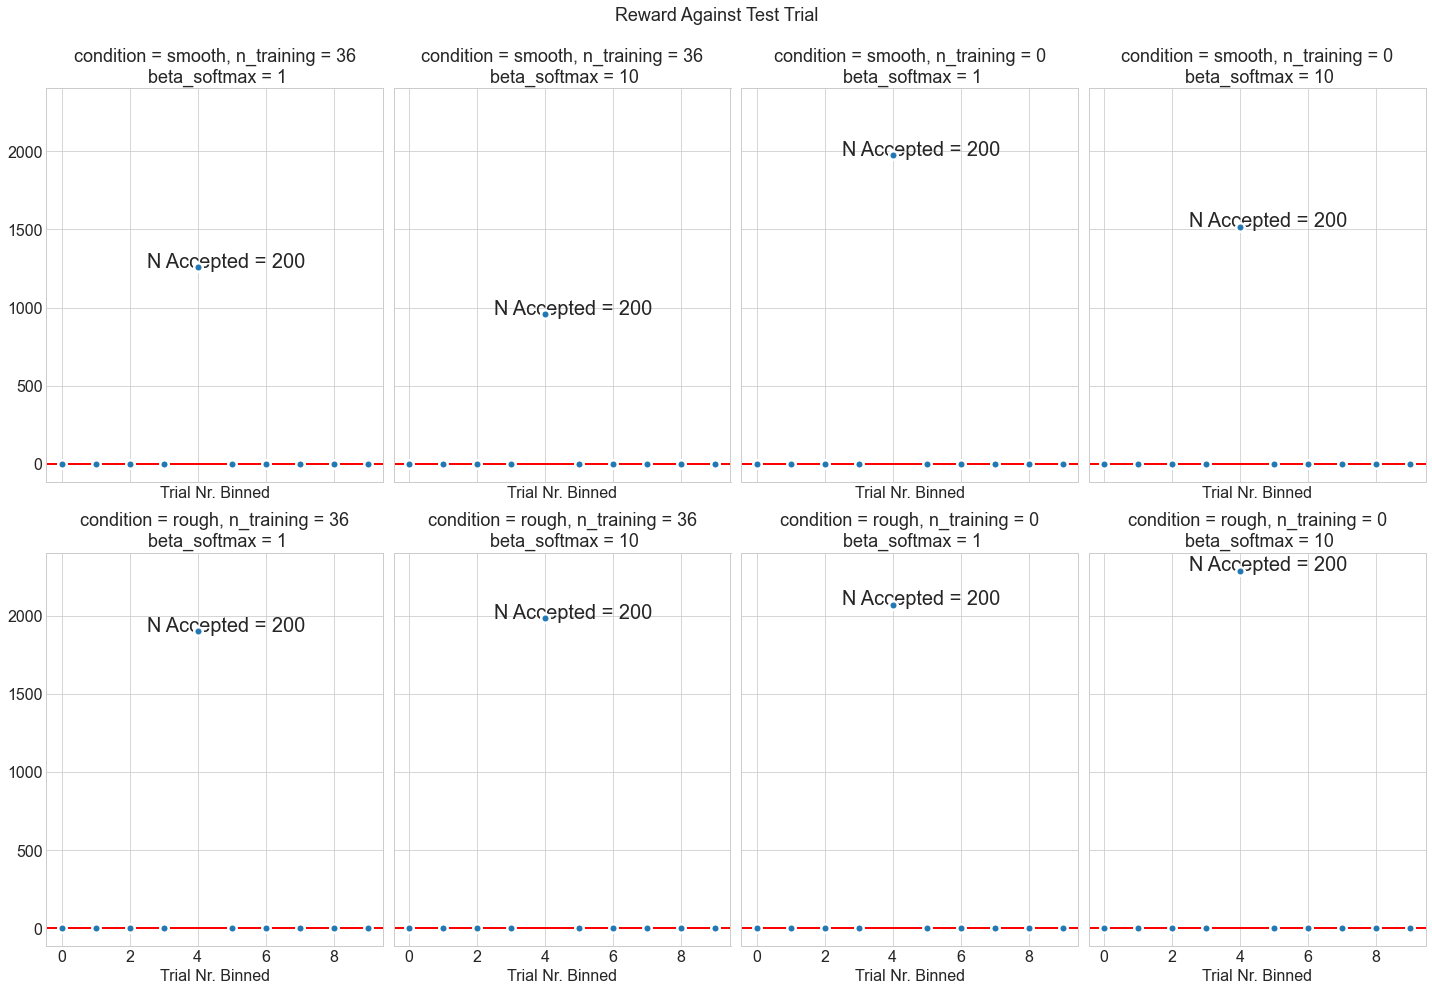

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(20, 14), sharex=True, sharey=True)
plot_uncertainty_over_test_partial = partial(plot_utils.plot_sum_over_bintime, var="reward")
list(map(plot_uncertainty_over_test_partial, list_df_reward, l_titles, axes.flatten()))
_ = fig.suptitle("Reward Against Test Trial\n")
plt.tight_layout()
str_note = "Note. y axes differ between panels"
# _ = plt.figtext(0.99, -0.02, str_note, horizontalalignment='right', size=25)